# Figure 1 - Simple Inconsistency Example

Here we create synthetic data to make XGBoost build the Model A and Model B from Figure 1 of the Tree SHAP paper. We then compute both individualized feature importances using Tree SHAP and Saabas, and global feature importances using Tree SHAP, gain, split count, and permutation.

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import shap
import xgboost as xgb

## Create Model A

This is just a simple AND function with a small amount of noise to force the creation of the left child split. Feature 0 is Fever and feature 1 is Cough.

In [2]:
N = 2000
X = np.zeros((N,2))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
yA = 80 * (X[:,0] * X[:,1]) + 1e-4 * ((X[:,0] == 0) * (X[:,1] == 0)) # last term forces the creation of left split
Xd = xgb.DMatrix(X)

In [3]:
# train a model with single tree
XdA = xgb.DMatrix(X, label=yA)
modelA = xgb.train({
    'eta': 1, 'max_depth': 3, 'base_score': 0, "lambda": 0
}, XdA, 1)
print(modelA.get_dump(with_stats=True)[0])

0:[f0<0.5] yes=1,no=2,missing=1,gain=799998,cover=2000
	1:[f1<0.5] yes=3,no=4,missing=3,gain=2.5e-06,cover=1000
		3:leaf=0.0001,cover=500
		4:leaf=-0,cover=500
	2:[f1<0.5] yes=5,no=6,missing=5,gain=1.6e+06,cover=1000
		5:leaf=-0,cover=500
		6:leaf=80,cover=500



## Create Model B

This is identical to Model A, except Cough is more important because it has its own marginal effect in addition to the original AND function in Model A.

In [4]:
yB = yA + X[:,1] * 10

In [5]:
# train a model with single tree
XdB = xgb.DMatrix(X, label=yB)
modelB = xgb.train({
    'eta': 1, 'max_depth': 3, 'base_score': 0, "lambda": 0
}, XdB, 1)
print(modelB.get_dump(with_stats=True)[0])

0:[f1<0.5] yes=1,no=2,missing=1,gain=1.25e+06,cover=2000
	1:[f0<0.5] yes=3,no=4,missing=3,gain=2.5e-06,cover=1000
		3:leaf=0.0001,cover=500
		4:leaf=-0,cover=500
	2:[f0<0.5] yes=5,no=6,missing=5,gain=1.6e+06,cover=1000
		5:leaf=10,cover=500
		6:leaf=90,cover=500



## SHAP Values

In [6]:
shap_valuesA = modelA.predict(Xd, pred_contribs=True)
shap_valuesA[0]

array([ 29.99998665,  29.99998665,  20.0000248 ], dtype=float32)

In [7]:
shap_valuesB = modelB.predict(Xd, pred_contribs=True)
shap_valuesB[0]

array([ 29.99998665,  34.99998856,  25.0000248 ], dtype=float32)

## Saabas Values

In [8]:
saabas_valuesA = modelA.predict(Xd, pred_contribs=True, approx_contribs=True)
saabas_valuesA[0]

array([ 19.9999752,  40.       ,  20.0000248], dtype=float32)

In [9]:
saabas_valuesB = modelB.predict(Xd, pred_contribs=True, approx_contribs=True)
saabas_valuesB[0]

array([ 40.       ,  24.9999752,  25.0000248], dtype=float32)

## mean(abs(SHAP Values))

In [10]:
np.abs(shap_valuesA).mean(0)

array([ 19.99999809,  19.99999809,  20.00000191], dtype=float32)

In [11]:
np.abs(shap_valuesB).mean(0)

array([ 19.99999809,  24.99999809,  25.00000191], dtype=float32)

## mean(abs(Saabas Values))

Note that the mean absolute Saabas values happen to be identical to the mean absolute SHAP values in this simple example, but in general this is not true.

In [12]:
np.abs(saabas_valuesA).mean(0)

array([ 19.99999809,  20.        ,  20.00000191], dtype=float32)

In [13]:
np.abs(saabas_valuesB).mean(0)

array([ 20.        ,  24.99999809,  25.00000191], dtype=float32)

## Split count

In [14]:
tmp = modelA.get_score(importance_type="weight")
splitsA_fever = tmp["f0"]
splitsA_cough = tmp["f1"]
splitsA_fever,splitsA_cough

(1, 2)

In [15]:
tmp = modelB.get_score(importance_type="weight")
splitsB_fever = tmp["f0"]
splitsB_cough = tmp["f1"]
splitsB_fever,splitsB_cough

(2, 1)

## Gain

For some reason XGBoost averages the gain instead of summing as is classically proposed by Brieman, Friedman and others. So we undo the average by multiplying by the split count. (The averaged version of the gain is also inconsistent, but just not with this example.)

In [20]:
tmp = modelA.get_score(importance_type="gain")
gainA_fever = tmp["f0"]*splitsA_fever
gainA_cough = tmp["f1"]*splitsA_cough 
total = gainA_fever+gainA_cough
gainA_fever /= total / 100
gainA_cough /= total / 100
gainA_fever,gainA_cough

(33.333277777696765, 66.66672222230325)

In [21]:
tmp["f0"]

799998.0

In [22]:
tmp["f1"]

800000.00000125

In [31]:
tmp = modelB.get_score(importance_type="gain")
gainB_fever = tmp["f0"] * splitsB_fever
gainB_cough = tmp["f1"] * splitsB_cough 
total = gainB_fever + gainB_cough
gainB_fever /= total / 100
gainB_cough /= total / 100
gainB_fever, gainB_cough

(56.14035087723146, 43.85964912276855)

In [32]:
tmp["f0"]*splitsB_fever/2000

800.00000000125

In [33]:
tmp["f1"]*splitsB_cough

1250000.0

In [34]:
1250000.0/2000

625.0

In [35]:
(90+10+0+0)/4

25.0

In [38]:
((90-25)**2 + (10-25)**2 + (0-25)**2 + (0-25)**2)/4

1425.0

In [38]:
((90-25)**2 + (10-25)**2 + (0-25)**2 + (0-25)**2)/4

1425.0

In [39]:
((90-50)**2 + (10-50)**2 + (0-0)**2 + (0-0)**2)/4

800.0

## Permutation

XGBoost does not implement permtation importance so we compute it ourselves.

In [18]:
def permute_importance(model, y):
    vals_fever = []
    Xtmp = X.copy()
    inds = list(range(Xtmp.shape[0]))
    for i in range(1000):
        np.random.shuffle(inds)
        Xtmp[:,0] = Xtmp[inds,0]
        err = y - model.predict(xgb.DMatrix(Xtmp))
        vals_fever.append(np.mean(np.sqrt(err*err)))
    
    vals_cough = []
    Xtmp = X.copy()
    inds = list(range(Xtmp.shape[0]))
    for i in range(1000):
        np.random.shuffle(inds)
        Xtmp[:,1] = Xtmp[inds,1]
        err = y - model.predict(xgb.DMatrix(Xtmp))
        vals_cough.append(np.mean(np.sqrt(err*err)))
    return np.mean(vals_fever),np.mean(vals_cough)

In [19]:
permuteA_fever,permuteA_cough = permute_importance(modelA, yA)
permuteA_fever,permuteA_cough

(19.99126498275, 19.98526500925)

In [20]:
permuteB_fever,permuteB_cough = permute_importance(modelB, yB)
permuteB_fever,permuteB_cough

(20.034424979099999, 25.004065000950632)

## Weighted Split Count

The weighted split count is another option in XGBoost, it is not inconsistent in this example, but is for other scenarios.

In [21]:
modelA.get_score(importance_type="cover")

{'f0': 2000.0, 'f1': 1000.0}

In [22]:
modelB.get_score(importance_type="cover")

{'f0': 1000.0, 'f1': 2000.0}

## Make plot

Here we make the core bar plot for Figure 1 of the paper.

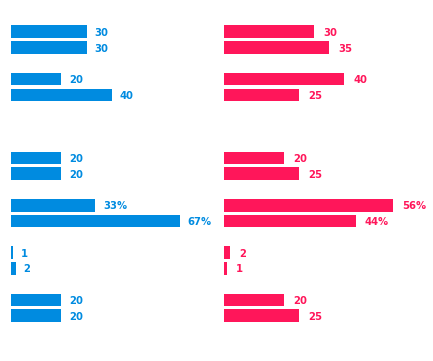

In [23]:
# fever
f = pl.figure(figsize=(7,6))
pl.subplot(1,2,1)
d = 2
values_A = [
    permuteA_fever,
    splitsA_fever,
    gainA_fever,
    np.abs(shap_valuesA).mean(0)[0],
    saabas_valuesA[0,0],
    shap_valuesA[0,0]
]
display_A = [str(int(round(v))) for v in values_A]
display_A[2] = str(int(display_A[2]))+"%"
positions_A = [
    1,
    4,
    7,
    10,
    13+d,
    16+d
]
values_B = [
    permuteA_cough,
    splitsA_cough,
    gainA_cough,
    np.abs(shap_valuesA).mean(0)[1],
    saabas_valuesA[0,1],
    shap_valuesA[0,1]
]
display_B = [str(int(round(v))) for v in values_B]
display_B[2] = str(int(display_B[2]))+"%"
positions_B = [
    0,
    3,
    6,
    9,
    12+d,
    15+d
]
pl.barh(positions_A, values_A, color="#008BE0")
pl.barh(positions_B, values_B, color="#008BE0")
pl.yticks([])
pl.axis('off')
for i, v in enumerate(values_A):
    pl.text(v + 3, positions_A[i]-0.25, str(display_A[i]), color='#008BE0', fontweight='bold')
for i, v in enumerate(values_B):
    pl.text(v + 3, positions_B[i]-0.25, str(display_B[i]), color='#008BE0', fontweight='bold')

# cough
pl.subplot(1,2,2)
d = 2
values_A = [
    permuteB_fever,
    splitsB_fever,
    gainB_fever,
    np.abs(shap_valuesB).mean(0)[0],
    saabas_valuesB[0,0],
    shap_valuesB[0,0]
]
display_A = [str(int(round(v))) for v in values_A]
display_A[2] = display_A[2]+"%"
positions_A = [
    1,
    4,
    7,
    10,
    13+d,
    16+d
]
values_B = [
    permuteB_cough,
    splitsB_cough,
    gainB_cough,
    np.abs(shap_valuesB).mean(0)[1],
    saabas_valuesB[0,1],
    shap_valuesB[0,1]
]
display_B = [str(int(round(v))) for v in values_B]
display_B[2] = str(int(display_B[2]))+"%"
positions_B = [
    0,
    3,
    6,
    9,
    12+d,
    15+d
]
pl.barh(positions_A, values_A, color="#FF165A")
pl.barh(positions_B, values_B, color="#FF165A")
pl.yticks([])
pl.axis('off')
for i, v in enumerate(values_A):
    pl.text(v + 3, positions_A[i]-0.25, str(display_A[i]), color='#FF165A', fontweight='bold')
for i, v in enumerate(values_B):
    pl.text(v + 3, positions_B[i]-0.25, str(display_B[i]), color='#FF165A', fontweight='bold')
    
pl.show()
#pl.savefig("data/bar.pdf")